## Setup & Data Loading

In [3]:
print("Installing required packages...")
%pip install yfinance > /dev/null 2>&1
%pip install torch torchvision torchaudio > /dev/null 2>&1
%pip install python-dotenv > /dev/null 2>&1
print("All packages installed.")

Installing required packages...
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
All packages installed.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os
import requests
import time

# scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
 
import yfinance as yf

## Datasets + Preprocessing

### 1: S&P500 - Yahoo Finance

In [3]:
# s&p500 and individual tech stocks
symbols = [
    '^GSPC',
    'META',
    'AMZN',
    'AAPL',
    'NFLX',
    'GOOG',
    'MSFT',
    'NVDA',
    'TSLA'
]
# 13 year range
start_date = "2012-01-01"
end_date = "2025-04-09"

In [4]:
data = yf.download(symbols, start=start_date, end=end_date, auto_adjust=True)
data.head()

[*********************100%***********************]  9 of 9 completed


Price           Close                                                          \
Ticker           AAPL    AMZN       GOOG META       MSFT       NFLX      NVDA   
Date                                                                            
2012-01-03  12.375392  8.9515  16.495003  NaN  21.077835  10.320000  0.321867   
2012-01-04  12.441896  8.8755  16.566145  NaN  21.573872  11.492857  0.325535   
2012-01-05  12.580026  8.8805  16.336349  NaN  21.794333  11.328571  0.337227   
2012-01-06  12.711536  9.1305  16.113497  NaN  22.132898  12.327143  0.333330   
2012-01-09  12.691371  8.9280  15.430305  NaN  21.841576  14.025714  0.333330   

Price                                   High  ...         Open     Volume  \
Ticker          TSLA        ^GSPC       AAPL  ...        ^GSPC       AAPL   
Date                                          ...                           
2012-01-03  1.872000  1277.060059  12.413611  ...  1258.859985  302220800   
2012-01-04  1.847333  1277.300049  12.479213  ...  1277.030029  260022000   
2012-01-05  1.808000  1281.060059  12.595674  ...  1277.300049  271269600   
2012-01-06  1.794000  1277.810059  12.722069  ...  1280.930054  318292800   
2012-01-09  1.816667  1280.699951  12.872535  ...  1277.829956  394024400   

Price                                                                  \
Ticker           AMZN       GOOG META      MSFT       NFLX       NVDA   
Date                                                                    
2012-01-03  102216000  147611217  NaN  64731500   29213800  468044000   
2012-01-04   84104000  114989399  NaN  80516100  100489900  347372000   
2012-01-05   76182000  131808205  NaN  56081400   86552900  563548000   
2012-01-06  140168000  108119746  NaN  99455500  125610800  533252000   
2012-01-09  101138000  233776981  NaN  59706800  214073300  508244000   

Price                             
Ticker          TSLA       ^GSPC  
Date                              
2012-01-03  13921500  3943710000  
2012-01-04   9451500  3592580000  
2012-01-05  15082500  4315950000  
2012-01-06  14794500  3656830000  
2012-01-09  13455000  3371600000  

[5 rows x 45 columns]

In [5]:
yfinance_returns = np.log(data['Close'] / data['Close'].shift(1)).dropna()
yfinance_returns

Ticker,AAPL,AMZN,GOOG,META,MSFT,NFLX,NVDA,TSLA,^GSPC
Date,,,,,,,,,
2012-05-21,0.056626,0.019725,0.022578,-0.116378,0.016266,0.025125,0.017235,0.042968,0.015909
2012-05-22,-0.007709,-0.012828,-0.021912,-0.093255,0.000336,-0.057815,-0.012280,0.068181,0.000486
2012-05-23,0.024107,0.009015,0.014311,0.031749,-0.022083,0.060181,0.024412,0.007118,0.001692
2012-05-24,-0.009226,-0.009433,-0.009562,0.031680,-0.001375,-0.023070,-0.026886,-0.024145,0.001379
2012-05-25,-0.005374,-0.010978,-0.020299,-0.034497,-0.000344,-0.000712,0.023665,-0.015644,-0.002168
...,...,...,...,...,...,...,...,...,...
2025-04-02,0.003131,0.019785,-0.000126,-0.003539,-0.000131,0.007661,0.002448,0.051897,0.006706
2025-04-03,-0.097013,-0.094081,-0.040007,-0.093852,-0.023914,-0.019941,-0.081281,-0.056302,-0.049606
2025-04-04,-0.075680,-0.042421,-0.032563,-0.051905,-0.036214,-0.069055,-0.076423,-0.110036,-0.061609


### 2: Alpha Vantage API
[Alpha Vantage API Documentation](https://www.alphavantage.co/documentation/#dailyadj)

In [6]:
load_dotenv()
function = "TIME_SERIES_DAILY"
api_key = os.getenv("ALPHA_VANTAGE_API_KEY")
symbol = "META"

In [7]:
response = requests.get(
    f"https://www.alphavantage.co/query?function={function}&symbol={symbol}&outputsize=full&apikey={api_key}"
)
json_data = response.json()

num_rows = len(json_data["Time Series (Daily)"])
print(f"There are {num_rows} days in this JSON object")

There are 3248 days in this JSON object


In [8]:
def parse(json_data):
    ts_key = "Time Series (Daily)"
    
    if "Error Message" in json_data:
        raise ValueError(f"Alpha Vantage API error: {json_data['Error Message']}")
    if "Note" in json_data:
        raise ValueError(f"Rate limit notice: {json_data['Note']}")
    if ts_key not in json_data:
        raise ValueError("Expected 'Time Series (Daily)' in response.")

    # Extract the raw time series data
    raw_data = json_data[ts_key]

    # Create DataFrame
    df = pd.DataFrame.from_dict(raw_data, orient="index")

    # Rename columns
    df.rename(columns={
        "1. open": "open",
        "2. high": "high",
        "3. low": "low",
        "4. close": "close",
        "5. volume": "volume"
    }, inplace=True)

    # Convert index to datetime and sort
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()

    # Convert column types
    df = df.astype({
        "open": float,
        "high": float,
        "low": float,
        "close": float,
        "volume": int
    })

    return df

In [9]:
df = parse(json_data)
df

,open,high,low,close,volume
2012-05-18,42.050,45.00,38.0000,38.2318,573576400
2012-05-21,36.530,36.66,33.0000,34.0300,168192700
2012-05-22,32.610,33.59,30.9400,31.0000,101786600
2012-05-23,31.370,32.50,31.3600,32.0000,73600000
2012-05-24,32.950,33.21,31.7700,33.0300,50237200
...,...,...,...,...,...
2025-04-11,535.505,547.40,528.5901,543.5700,17642327
2025-04-14,556.175,557.77,528.2800,531.4800,14130928
2025-04-15,532.105,537.94,517.5000,521.5200,15558659
2025-04-16,508.510,513.37,495.6300,502.3100,18735075


In [10]:
vantage_returns = np.log(df["close"] / df["close"].shift(1)).dropna()
vantage_returns

2012-05-21   -0.116425
2012-05-22   -0.093255
2012-05-23    0.031749
2012-05-24    0.031680
2012-05-25   -0.034497
                ...   
2025-04-11   -0.004991
2025-04-14   -0.022493
2025-04-15   -0.018918
2025-04-16   -0.037530
2025-04-17   -0.001654
Name: close, Length: 3247, dtype: float64

In [11]:
yfinance_returns

Ticker,AAPL,AMZN,GOOG,META,MSFT,NFLX,NVDA,TSLA,^GSPC
Date,,,,,,,,,
2012-05-21,0.056626,0.019725,0.022578,-0.116378,0.016266,0.025125,0.017235,0.042968,0.015909
2012-05-22,-0.007709,-0.012828,-0.021912,-0.093255,0.000336,-0.057815,-0.012280,0.068181,0.000486
2012-05-23,0.024107,0.009015,0.014311,0.031749,-0.022083,0.060181,0.024412,0.007118,0.001692
2012-05-24,-0.009226,-0.009433,-0.009562,0.031680,-0.001375,-0.023070,-0.026886,-0.024145,0.001379
2012-05-25,-0.005374,-0.010978,-0.020299,-0.034497,-0.000344,-0.000712,0.023665,-0.015644,-0.002168
...,...,...,...,...,...,...,...,...,...
2025-04-02,0.003131,0.019785,-0.000126,-0.003539,-0.000131,0.007661,0.002448,0.051897,0.006706
2025-04-03,-0.097013,-0.094081,-0.040007,-0.093852,-0.023914,-0.019941,-0.081281,-0.056302,-0.049606
2025-04-04,-0.075680,-0.042421,-0.032563,-0.051905,-0.036214,-0.069055,-0.076423,-0.110036,-0.061609


In [12]:
vantage_returns

2012-05-21   -0.116425
2012-05-22   -0.093255
2012-05-23    0.031749
2012-05-24    0.031680
2012-05-25   -0.034497
                ...   
2025-04-11   -0.004991
2025-04-14   -0.022493
2025-04-15   -0.018918
2025-04-16   -0.037530
2025-04-17   -0.001654
Name: close, Length: 3247, dtype: float64

## Exploratory Analysis

# new exp

In [13]:
# Basic stats and structure
print(f'Shape of returns data: {yfinance_returns.shape}')
print(f'Date range: {yfinance_returns.index.min()} to {yfinance_returns.index.max()}')
print(f'Missing values: {yfinance_returns.isna().sum().sum()}')

# Summary statistics
print(yfinance_returns.describe())

Shape of returns data: (3240, 9)
Date range: 2012-05-21 00:00:00 to 2025-04-08 00:00:00
Missing values: 0
Ticker         AAPL         AMZN         GOOG         META         MSFT  \
count   3240.000000  3240.000000  3240.000000  3240.000000  3240.000000   
mean       0.000735     0.000855     0.000706     0.000801     0.000840   
std        0.017822     0.020178     0.017184     0.025108     0.016467   
min       -0.137708    -0.151398    -0.117667    -0.306391    -0.159454   
25%       -0.007523    -0.008836    -0.007115    -0.010064    -0.006853   
50%        0.000899     0.000891     0.000846     0.001040     0.000732   
75%        0.010177     0.011553     0.009257     0.012721     0.009365   
max        0.113157     0.132178     0.148872     0.259371     0.132929   

Ticker         NFLX         NVDA         TSLA        ^GSPC  
count   3240.000000  3240.000000  3240.000000  3240.000000  
mean       0.001379     0.001806     0.001480     0.000416  
std        0.029519     0.028464   

* All stocks show positive mean daily returns, indicating generally positive performance over this 13-year period.
* NVDA has the highest average daily return (0.001806 or about 0.18% per day)
* The S&P 500 (^GSPC) has the lowest average daily return at 0.000416 (about 0.04% per day)
* tech stocks significantly outperformed the broader market during this period
* TSLA shows the highest volatility 
* there are higher stock volatilities-- using dimensionality reduction makes sense here 
* META experienced the most extreme negative return; NFLX had the most extreme positive return 
* slight upward drift 
* there are varying scales of volatility across stocks-- need standardization before doing dimensionality reduction 
* The presence of extreme returns (as seen in min/max values) suggests that anomaly detection methods should be effective in identifying unusual market events.

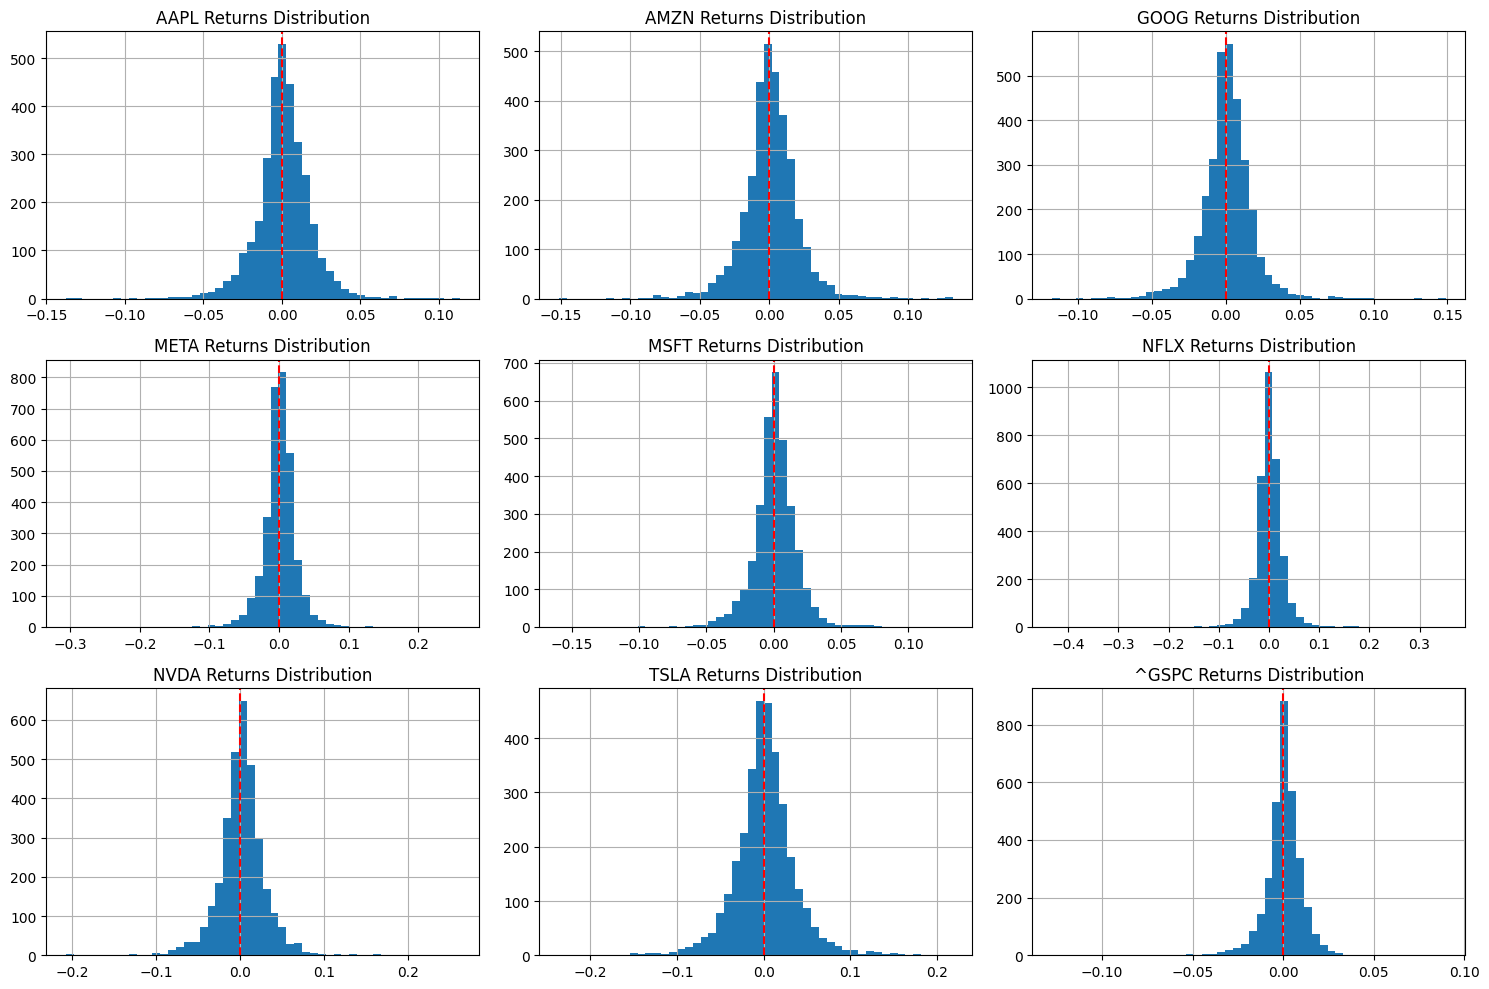

In [14]:
# Simple histograms
plt.figure(figsize=(15, 10))
for i, symbol in enumerate(yfinance_returns.columns):
    plt.subplot(3, 3, i+1)
    yfinance_returns[symbol].hist(bins=50)
    plt.title(f'{symbol} Returns Distribution')
    plt.axvline(0, color='red', linestyle='--')
plt.tight_layout()

* All distributions show more concentration around the mean (the peak) and fatter tails than a normal distribution would have.
* excess kurtosis-> financial markets 
* All distributions are centered close to zero, aligned with the efficient market hypothesis that predicts stock returns should center around zero in the short term.

In [15]:
import seaborn as sns

Text(0.5, 1.0, 'Correlation Matrix of Stock Returns')

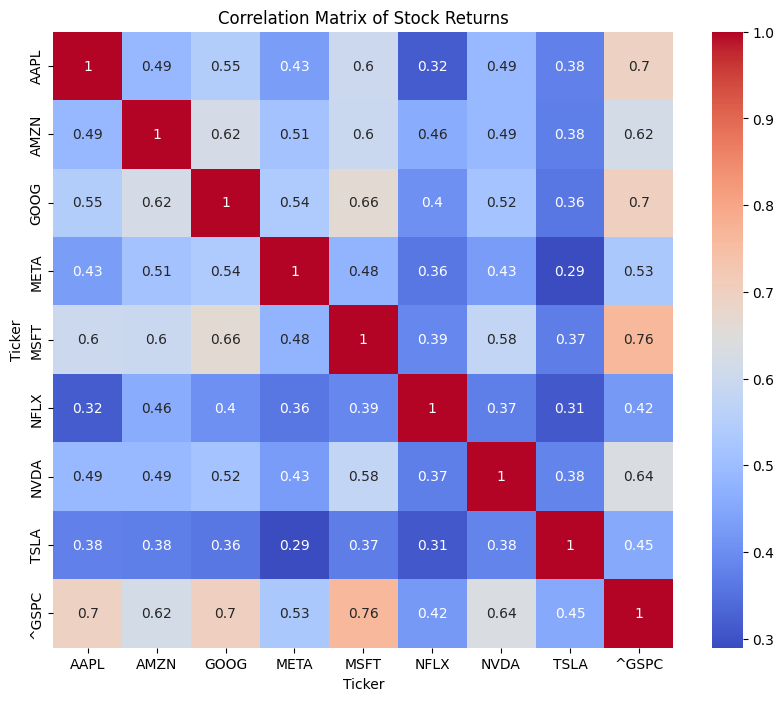

In [16]:
# Correlation heatmap
correlation_matrix = yfinance_returns.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Stock Returns')

* basically for each stock, we have the daily log returns: log(today's price / yesterday's price)-> the correlation measures how these returns move together day by day
* overall, most correlations are positive and moderate to strong (0.3-0.7 range), indicating that these tech stocks generally move together
* the average correlation appears to be around 0.5, suggesting approximately half of the movement in these stocks is explained by common factors
* the S&P 500 (^GSPC) shows the strongest average correlation with individual stocks, which is expected as it represents the broader market
* MSFT (0.76), AAPL (0.70), and GOOG (0.70) have the strongest relationships with the S&P 500

## Stock by stock 
Microsoft (MSFT):

* Shows consistently strong correlations with other stocks (0.58-0.66 with most tech peers)
* Has the strongest correlation with the S&P 500 (0.76)
* returns seem most heavily influenced by broader market factors

Netflix (NFLX):

Shows the lowest correlations with other stocks (mostly 0.3-0.4)
Even its correlation with the S&P 500 is relatively low (0.42)
This indicates NFLX has more company-specific (idiosyncratic) factors driving its returns

Tesla (TSLA):

Also shows relatively low correlations (0.29-0.38 with other tech stocks)
Its highest correlation is with the S&P 500 (0.45)
Like NFLX, TSLA appears to march to its own drummer more than other tech stocks


Google (GOOG) and Apple (AAPL):

Both show strong correlations with the S&P 500 (0.70) and with each other (0.55)
These companies appear to be similarly affected by market-wide factors


Meta (META):

Shows the lowest correlation with TSLA (0.29)
Has moderate correlations with most stocks (0.4-0.5 range)
Not as closely tied to market movements as MSFT, AAPL, or GOOG

## Groupings 
High market sensitivity group: MSFT, AAPL, GOOG (correlations with S&P 500 > 0.7)
Moderate market sensitivity: NVDA, AMZN (correlations with S&P 500 in 0.6 range)
Lower market sensitivity: META, NFLX, TSLA (correlations with S&P 500 < 0.55)

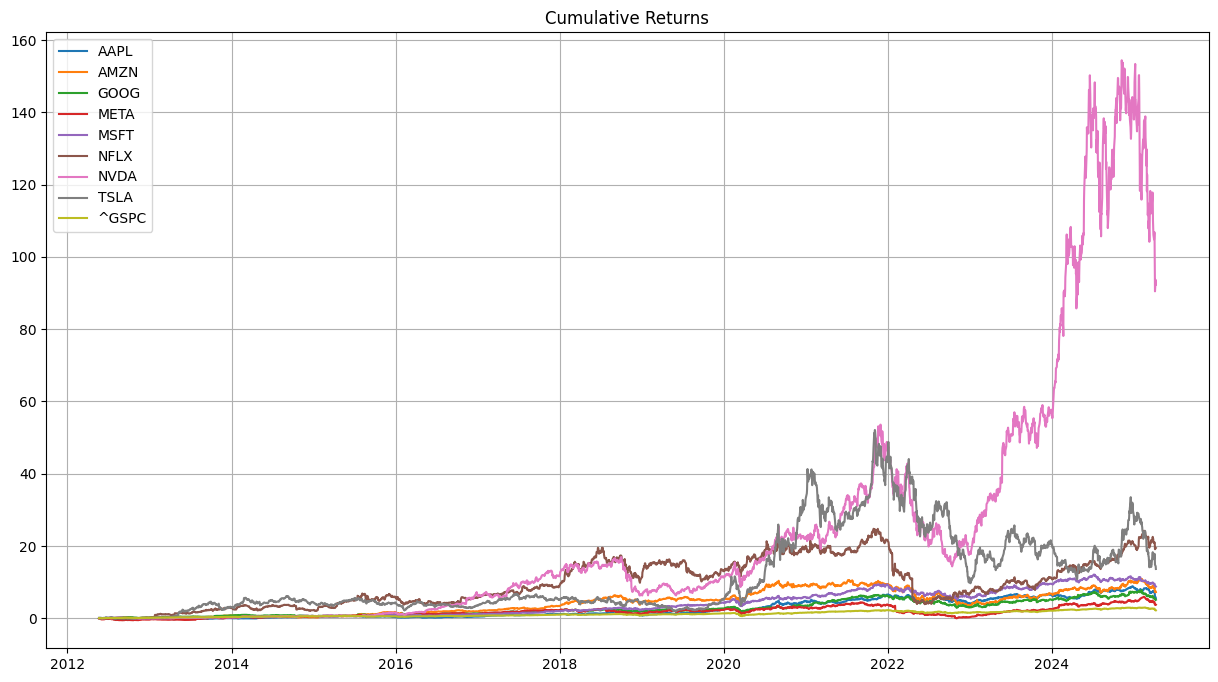

In [17]:
# Cumulative returns
cumulative_returns = (1 + yfinance_returns).cumprod() - 1
plt.figure(figsize=(15, 8))
for col in cumulative_returns.columns:
    plt.plot(cumulative_returns.index, cumulative_returns[col], label=col)
plt.title('Cumulative Returns')
plt.legend()
plt.grid(True)

Starting from 2012, NVDA shows:

Moderate growth until around 2016
Accelerated growth from 2016-2018
A temporary plateau in 2018-2020
Explosive growth starting in 2020

Tesla (TSLA) shows the second-best performance but with extreme volatility:

Relatively flat performance until around 2019
Dramatic surge during 2020-2021, reaching approximately 50x returns
Significant decline after 2021
Currently showing returns of about 20x the initial investment

Relative Performance Tiers
- The stocks fall into clear performance tiers:

Exceptional tier: NVDA (90-150x returns)
High performer: TSLA (15-20x returns)
Solid performers: AMZN, NFLX, AAPL, MSFT (5-10x returns)
Moderate performers: GOOG (approximately 4-5x returns)
Laggards: META (approximately 2-3x returns)
Benchmark: S&P 500 (^GSPC) (approximately 2x returns)

In [18]:
z_scores = (yfinance_returns - yfinance_returns.mean()) / yfinance_returns.std()
max_abs_z_scores = abs(z_scores).max(axis=1)
# Identify days with outliers (any z-score > 3)
outlier_days = max_abs_z_scores[max_abs_z_scores > 3]

# Sort the outlier days by z-score 
sorted_outliers = outlier_days.sort_values(ascending=False)
print("\nTop 10 most extreme outlier days:")
for date, max_z in sorted_outliers.head(10).items():
    extreme_stock = abs(z_scores.loc[date]).idxmax()
    actual_return = yfinance_returns.loc[date, extreme_stock]
    print(f"{date.strftime('%Y-%m-%d')}: {extreme_stock} moved {actual_return:.2%} (z-score: {max_z:.2f})")
    
#what stocks cause the most outliers
outlier_counts = pd.Series(index=yfinance_returns.columns, dtype=int).fillna(0)
for date in sorted_outliers.index:
    extreme_stocks = yfinance_returns.columns[abs(z_scores.loc[date]) > 3]
    for stock in extreme_stocks:
        outlier_counts[stock] += 1

print("\nNumber of outlier days by stock:")
print(outlier_counts.sort_values(ascending=False))


Top 10 most extreme outlier days:
2022-04-20: NFLX moved -43.26% (z-score: 14.70)
2022-02-03: META moved -30.64% (z-score: 12.23)
2020-03-16: ^GSPC moved -12.77% (z-score: 12.00)
2013-01-24: NFLX moved 35.22% (z-score: 11.89)
2022-10-27: META moved -28.18% (z-score: 11.26)
2013-07-25: META moved 25.94% (z-score: 10.30)
2012-07-25: NFLX moved -28.79% (z-score: 9.80)
2020-03-12: ^GSPC moved -9.99% (z-score: 9.41)
2016-11-11: NVDA moved 26.09% (z-score: 9.10)
2015-07-17: GOOG moved 14.89% (z-score: 8.62)

Number of outlier days by stock:
Ticker
TSLA     55.0
AMZN     52.0
AAPL     50.0
GOOG     50.0
MSFT     45.0
NFLX     45.0
^GSPC    45.0
META     40.0
NVDA     39.0
dtype: float64


<Figure size 1200x800 with 0 Axes>

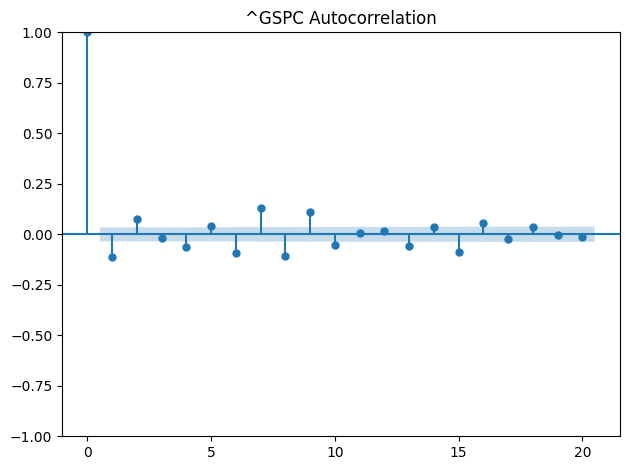

Lag 1 Autocorrelation:
^GSPC: -0.1134


In [19]:
# Basic autocorrelation analysis
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
import pandas as pd
symbol = '^GSPC' 
plt.figure(figsize=(12, 8))
returns = yfinance_returns[symbol].dropna()
plot_acf(returns, lags=20, alpha=0.05, title=f'{symbol} Autocorrelation')
plt.tight_layout()
plt.savefig(f'{symbol}_autocorrelation.png')
plt.show()
print("Lag 1 Autocorrelation:")
lag_1_corr = returns.autocorr(lag=1)
print(f"{symbol}: {lag_1_corr:.4f}")

# notes on autocorrelation
- The tall spike at lag 0 shows a perfect correlation of 1.0, which is expected (today's returns always perfectly correlate with themselves).
- the S&P 500 shows evidence of short-term mean reversion (negative lag 1 autocorrelation), but beyond that one-day effect, returns behave largely as a random walk.
- At lag 1, there's a negative autocorrelation of -0.1134, suggesting a mild tendency for returns to reverse direction from one day to the next - when the market goes up one day, it has a slight tendency to go down the next day (and vice versa).

In [20]:
import seaborn as sns

## Outlier Detection

In [38]:
# traditional methods
def detect_outliers_iqr(data, threshold=1.5):
  q1 = np.percentile(data, 25)
  q3 = np.percentile(data, 75)
  iqr = q3 - q1
  return (data < q1 - threshold*iqr) | (data > q3 + threshold*iqr)

In [39]:
outliers_traditional = detect_outliers_iqr(returns_scaled)

NameError: name 'returns_scaled' is not defined

In [ ]:
# ML-based (Isolation Forest)
iso_forest = IsolationForest(contamination=0.05, random_state=42)
outliers = iso_forest.fit_predict(returns_scaled)

In [ ]:
# Comparing results
print(f"Traditional IQR outliers: {np.sum(outliers_traditional)}")
print(f"Isolation Forest outliers: {np.sum(outliers == -1)}")

## Uncovering Latent Structures: PCA vs Nonlinear PCA (Autoencoder)

### Traditional PCA

swapped the old var with yfinance_returns everwhere but that changed the plots/values-- check that

In [22]:
# Traditional PCA Analysis
X_scaled = StandardScaler().fit_transform(yfinance_returns)

# Fit PCA
pca = PCA(n_components=3)
pca_factors = pca.fit_transform(X_scaled)
pca_returns_df = pd.DataFrame(pca_factors, index=yfinance_returns.index, columns=["f1", "f2", "f3"])

In [23]:
pca_exposures_df = pd.DataFrame(index=yfinance_returns.columns, columns=["f1", "f2", "f3"]).astype(float)

for asset in yfinance_returns.columns:
    lr = LinearRegression()
    lr.fit(pca_returns_df, yfinance_returns[asset].values)
    pca_exposures_df.loc[asset] = lr.coef_

In [24]:
# returns a vector of explained variance by each component
pct = pca.explained_variance_ratio_

# get the influence each component has on the features
pca_components = pca.components_

(0.0, 100.0)

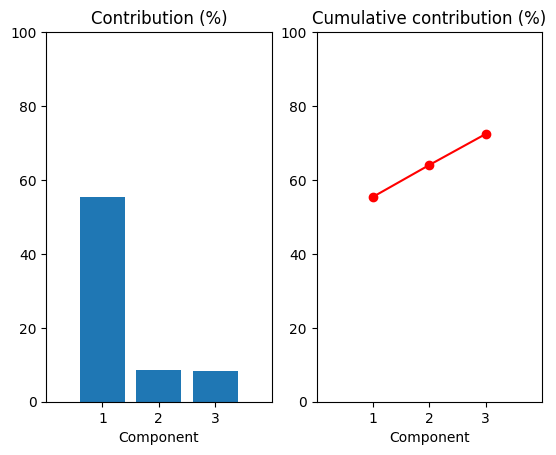

In [25]:
# plotting
cum_pct = np.cumsum(pct)
x = np.arange(1, len(pct)+1, 1)

plt.subplot(1, 2, 1)
plt.bar(x, pct * 100, align="center")
plt.title("Contribution (%)")
plt.xlabel('Component')
plt.xticks(x)
plt.xlim([0, 4])
plt.ylim([0, 100])

plt.subplot(1, 2, 2)
plt.plot(x, cum_pct * 100, 'ro-')
plt.title('Cumulative contribution (%)')
plt.xlabel('Component')
plt.xticks(x)
plt.xlim([0, 4])
plt.ylim([0, 100])

In [26]:
# multiply returns by components and transpose the dataframe
X = np.asarray(yfinance_returns)

factor_returns = X.dot(pca_components.T)

# recall that we set n_components=3 earlier to denote how many principal components we want
factor_returns = pd.DataFrame(
    columns=["f1", "f2", "f3"],
    index=yfinance_returns.index,
    data=factor_returns
)

factor_returns.head()

,f1,f2,f3
Date,,,
2012-05-21,-0.034164,-0.016855,-0.077611
2012-05-22,0.045160,0.000968,-0.111989
2012-05-23,-0.044159,-0.041568,0.025641
2012-05-24,0.021176,0.024789,0.023859
2012-05-25,0.020887,0.004525,-0.010102


In [27]:
# plot the portfolio returns influenced by the first factor
factor_exposures = pd.DataFrame(
    index=["f1", "f2", "f3"],
    columns=yfinance_returns.columns,
    data = pca_components
).T

factor_exposures

,f1,f2,f3
Ticker,,,
AAPL,-0.336531,0.299888,-0.223877
AMZN,-0.349491,-0.099142,0.228253
GOOG,-0.365492,0.151456,0.155372
META,-0.305070,0.031314,0.398382
MSFT,-0.372971,0.237662,-0.016927
NFLX,-0.260592,-0.733539,0.376196
NVDA,-0.330440,0.062036,-0.142906
TSLA,-0.251986,-0.492390,-0.735976
^GSPC,-0.397804,0.188305,-0.105064


Text(0.5, 1.0, 'Asset Loadings on Principal Component 1')

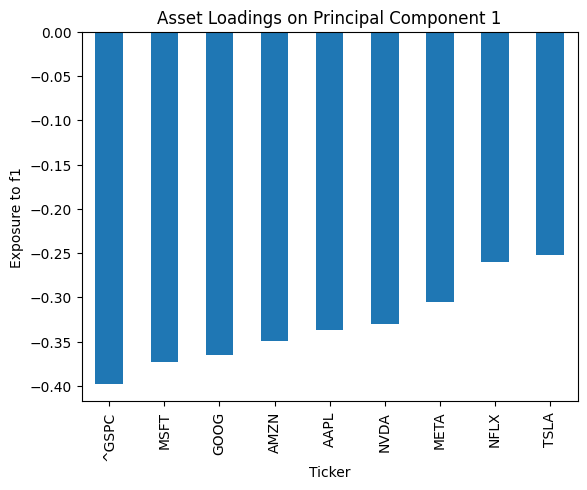

In [28]:
factor_exposures.f1.sort_values().plot.bar()
plt.ylabel("Exposure to f1")
plt.title("Asset Loadings on Principal Component 1")

The bar chart plots the loadings (or exposures) of the first principal component (f1) across all the assets in the portfolio (including ^GSPC, AAPL, MSFT, etc.).

These values represent how much each asset contributes to the first principal component, which typically captures the largest source of variance in the dataset.

Analysis:
* TSLA, NVDA, and NFLX have high positive exposures to the first principal component, suggesting they are strongly aligned with the main factor driving portfolio variance.

* ^GSPC (S&P 500) has the lowest exposure, meaning its behavior is less influenced by this main factor compared to the others.

* This makes sense—^GSPC is a broad market index, often more diversified and stable.

* Stocks like AAPL, MSFT, GOOG are in the middle — they move with the first factor, but not as strongly as TSLA or NVDA.

* Given that tech/growth stocks (like TSLA, NVDA) dominate the top end, `f1` could be interpreted as a “growth/tech risk factor”.

Text(0.5, 1.0, 'Asset Loadings on Principal Component 2')

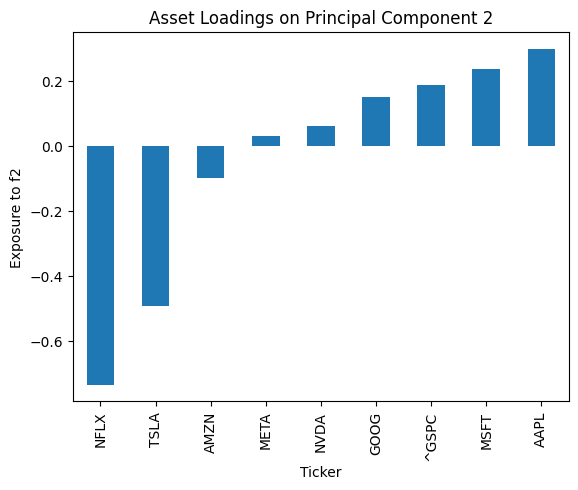

In [29]:
factor_exposures.f2.sort_values().plot.bar()
plt.ylabel("Exposure to f2")
plt.title("Asset Loadings on Principal Component 2")

TSLA loads heavily positive on f2, and several other tech stocks like NFLX, META, NVDA load negatively, while the rest (including the index) are near neutral.

`f2` might capture a unique risk or return profile specific to TSLA, such as:
* Idiosyncratic volatility or momentum (TSLA often behaves very differently from even other tech stocks) - most likely due to recent political events
* A "speculative growth" factor (TSLA being the face of that in recent years)

Text(0.5, 1.0, 'Asset Loadings on Principal Component 3')

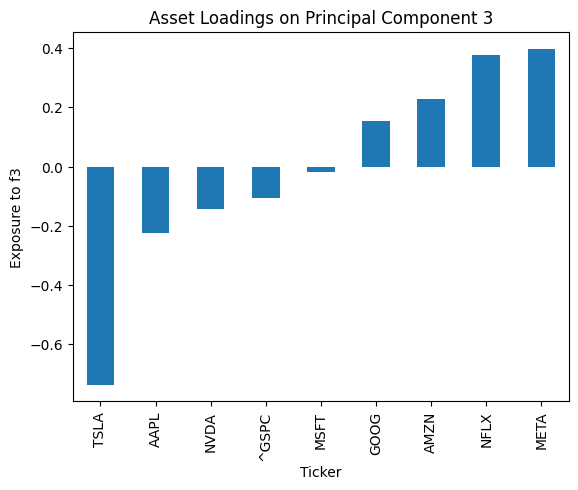

In [30]:
factor_exposures.f3.sort_values().plot.bar()
plt.ylabel("Exposure to f3")
plt.title("Asset Loadings on Principal Component 3")

From the plot:
* NFLX has a very strong positive exposure to f3 (~0.85+)
* NVDA has a strong negative exposure (~-0.4)
* META, AAPL, MSFT, GOOG, etc. have mild to moderate negative exposures
* TSLA and AMZN are slightly positive

This kind of distribution suggests that f3 might represent a volatility or risk sentiment factor — for example:
* High positive exposure (NFLX): Might reflect a unique return pattern or idiosyncratic risk (e.g., high beta, high growth, high volatility).
* High negative exposure (NVDA, META): Suggests an opposite movement — perhaps NVDA's price movements diverge from those of NFLX in this principal component's dimension.
* Other large-cap stocks are close to neutral or slightly negative.



### Autoencoder

We will define our model in the following ways:
* Architecture: Encoder: input -> 64 neurons -> latent; Decoder: latent -> 64 neurons -> input
* Objective: MSE loss during training
* Latent Representation: `latent = self.encoder(x)` -> 3D representation
* Optimization: Adam optimizer used in training loop

In [31]:
# Defining Autoencoder (PyTorch)
class Autoencoder(nn.Module):
  def __init__(self, input_dim, latent_dim):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Linear(input_dim, 128),
        nn.ReLU(),
        nn.Linear(128, latent_dim)
    )
    self.decoder = nn.Sequential(
        nn.Linear(latent_dim, 128),
        nn.ReLU(),
        nn.Linear(128, input_dim)
    )

  def forward(self, x):
    latent = self.encoder(x)
    reconstructed = self.decoder(latent)
    return reconstructed, latent

In [32]:
# Standardize the returns data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(yfinance_returns)
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)

In [33]:
input_dim = X_tensor.shape[1]  # e.g., 10 stocks
latent_dim = 3                 # same as n_components in PCA

model = Autoencoder(input_dim, latent_dim)

In [34]:
# training
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

for epoch in range(1000):
    model.train()
    optimizer.zero_grad()
    recon, z = model(X_tensor)
    loss = loss_fn(recon, X_tensor)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 1.0114
Epoch 100, Loss: 0.2489
Epoch 200, Loss: 0.2148
Epoch 300, Loss: 0.1978
Epoch 400, Loss: 0.1897
Epoch 500, Loss: 0.1842
Epoch 600, Loss: 0.1805
Epoch 700, Loss: 0.1759
Epoch 800, Loss: 0.1736
Epoch 900, Loss: 0.1712


In [35]:
# Extract latent features
with torch.no_grad():
    _, factor_returns = model(X_tensor)

factor_returns_df = pd.DataFrame(
    factor_returns.numpy(),
    index=yfinance_returns.index,
    columns=["f1", "f2", "f3"]
)

factor_exposures_df = factor_exposures_df = pd.DataFrame(index=yfinance_returns.columns, columns=["f1", "f2", "f3"]).astype(float)

for asset in yfinance_returns.columns:
    lr = LinearRegression()
    lr.fit(factor_returns_df, yfinance_returns[asset].values)
    factor_exposures_df.loc[asset] = lr.coef_

factor_exposures_df

,f1,f2,f3
Ticker,,,
AAPL,-0.003529,-0.005532,-0.000554
AMZN,-0.005061,-0.003088,-0.002298
GOOG,-0.004000,-0.004050,-0.002644
META,-0.006023,0.000807,-0.007080
MSFT,-0.004039,-0.003828,-0.001769
NFLX,-0.008636,0.003348,0.003136
NVDA,-0.008605,0.001591,-0.004133
TSLA,-0.011285,0.008717,-0.000214
^GSPC,-0.002860,-0.002606,-0.000947


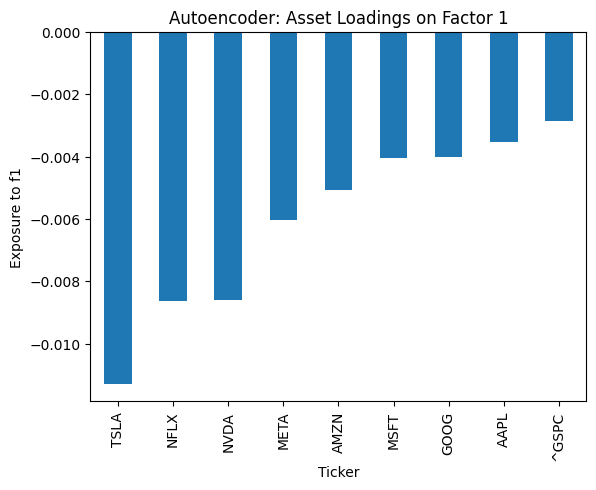

In [36]:
factor_exposures_df["f1"].sort_values().plot(kind='bar')
plt.ylabel("Exposure to f1")
plt.title("Autoencoder: Asset Loadings on Factor 1")
plt.show()

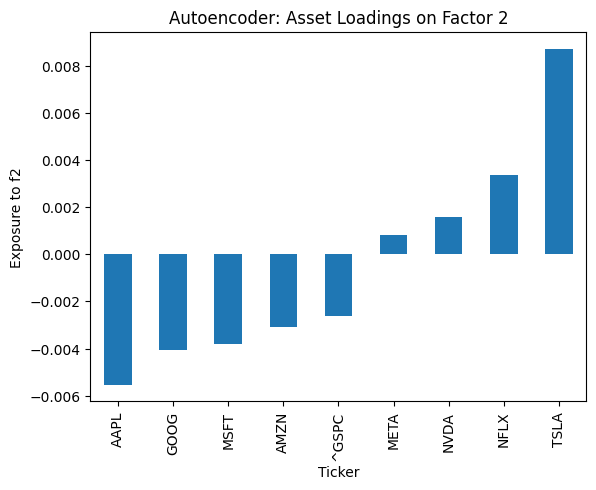

In [37]:
factor_exposures_df["f2"].sort_values().plot(kind='bar')
plt.ylabel("Exposure to f2")
plt.title("Autoencoder: Asset Loadings on Factor 2")
plt.show()

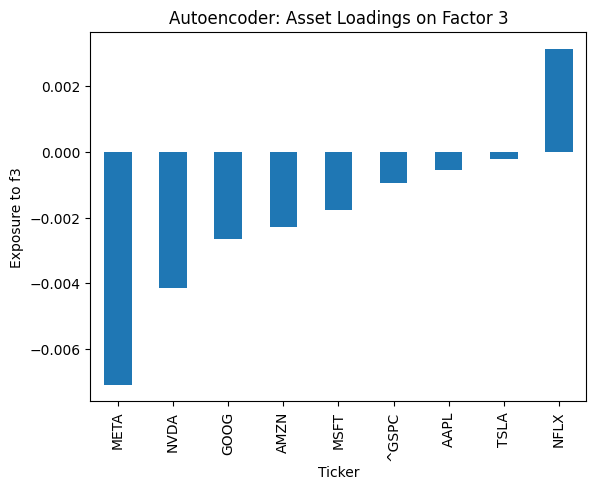

In [38]:
factor_exposures_df["f3"].sort_values().plot(kind='bar')
plt.ylabel("Exposure to f3")
plt.title("Autoencoder: Asset Loadings on Factor 3")
plt.show()

### Comparing Metrics

In [39]:
results = []

for asset in yfinance_returns.columns:
    y_true = yfinance_returns[asset].values

    # Autoencoder prediction
    y_pred_ae = factor_returns_df.values @ factor_exposures_df.loc[asset].values
    r2_ae = r2_score(y_true, y_pred_ae)
    mse_ae = mean_squared_error(y_true, y_pred_ae)

    # PCA prediction
    y_pred_pca = pca_returns_df.values @ pca_exposures_df.loc[asset].values
    r2_pca = r2_score(y_true, y_pred_pca)
    mse_pca = mean_squared_error(y_true, y_pred_pca)

    results.append({
        "Ticker": asset,
        "R2_Autoencoder": r2_ae,
        "R2_PCA": r2_pca,
        "MSE_Autoencoder": mse_ae,
        "MSE_PCA": mse_pca
    })

comparison_df = pd.DataFrame(results).set_index("Ticker")

In [40]:
print(comparison_df.sort_values("R2_Autoencoder", ascending=False))

        R2_Autoencoder    R2_PCA  MSE_Autoencoder   MSE_PCA
Ticker                                                     
^GSPC         0.686394  0.823855         0.000036  0.000020
GOOG          0.617819  0.700807         0.000113  0.000088
MSFT          0.599431  0.735480         0.000109  0.000072
META          0.583061  0.583821         0.000263  0.000262
NVDA          0.543020  0.559142         0.000370  0.000357
AMZN          0.531055  0.654541         0.000191  0.000141
AAPL          0.511750  0.670950         0.000155  0.000104
NFLX          0.485088  0.860969         0.000449  0.000121
TSLA          0.478960  0.911949         0.000677  0.000114


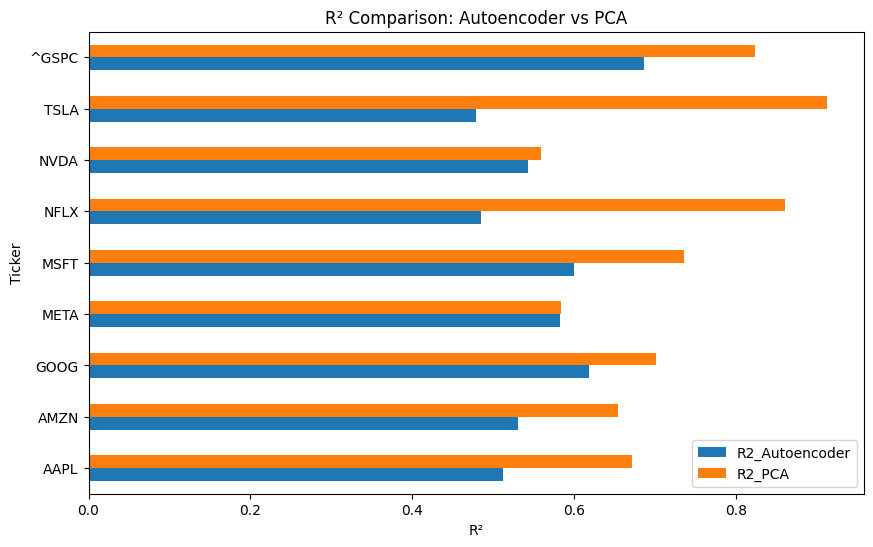

In [41]:
comparison_df[["R2_Autoencoder", "R2_PCA"]].plot(kind='barh', figsize=(10,6))
plt.title("R² Comparison: Autoencoder vs PCA")
plt.xlabel("R²")
plt.show()

Analysis:
* PCA consistently has higher R² for all assets — meaning it explains more variance in the returns.
* Even for nonlinear-looking assets like TSLA or NVDA, PCA still edges out the Autoencoder.
* For assets like ^GSPC, TSLA, and NFLX, PCA does significantly better.


In this specific setup, PCA outperforms the autoencoder in explaining asset return variance.

This might mean:
* Returns are fairly linear, and PCA is sufficient
* Autoencoder is underfitting (can be improved by deeper architecture, more training, or tuning)
* The autoencoder’s latent space isn't well-aligned with the factors driving return variance (which is okay — it's nonlinear!)

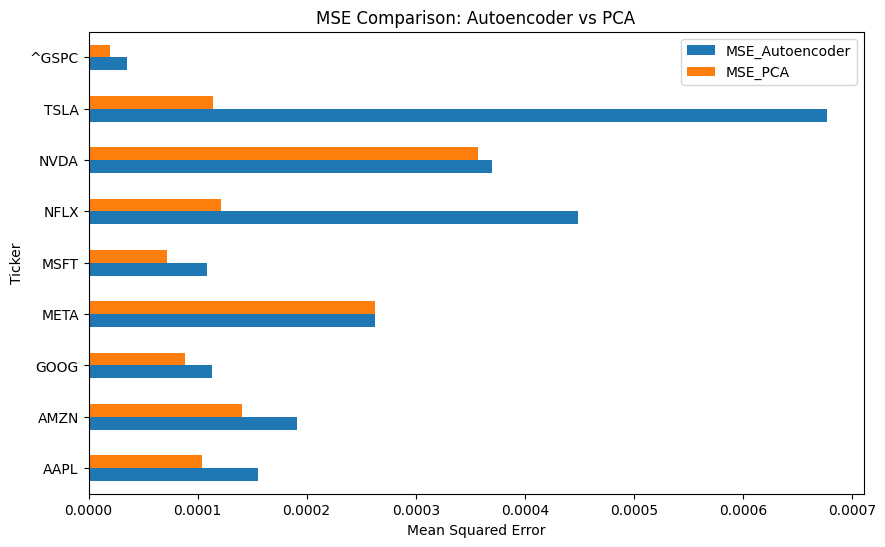

In [42]:
comparison_df[["MSE_Autoencoder", "MSE_PCA"]].plot(
    kind='barh', figsize=(10, 6), title="MSE Comparison: Autoencoder vs PCA"
)
plt.xlabel("Mean Squared Error")
plt.show()

Analysis:
* For every asset, PCA (orange) has a lower or equal MSE compared to Autoencoder (blue).
* This matches with the R² plot since Lower MSE ⟺ Higher R²
* TSLA, NVDA, NFLX: Autoencoder struggles most here — much higher MSE than PCA
* ^GSPC, GOOG, MSFT: Autoencoder performs relatively closer to PCA
* META, AAPL, AMZN: PCA still consistently does better, but the gap is smaller

## Clustering on Latent Features

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to '

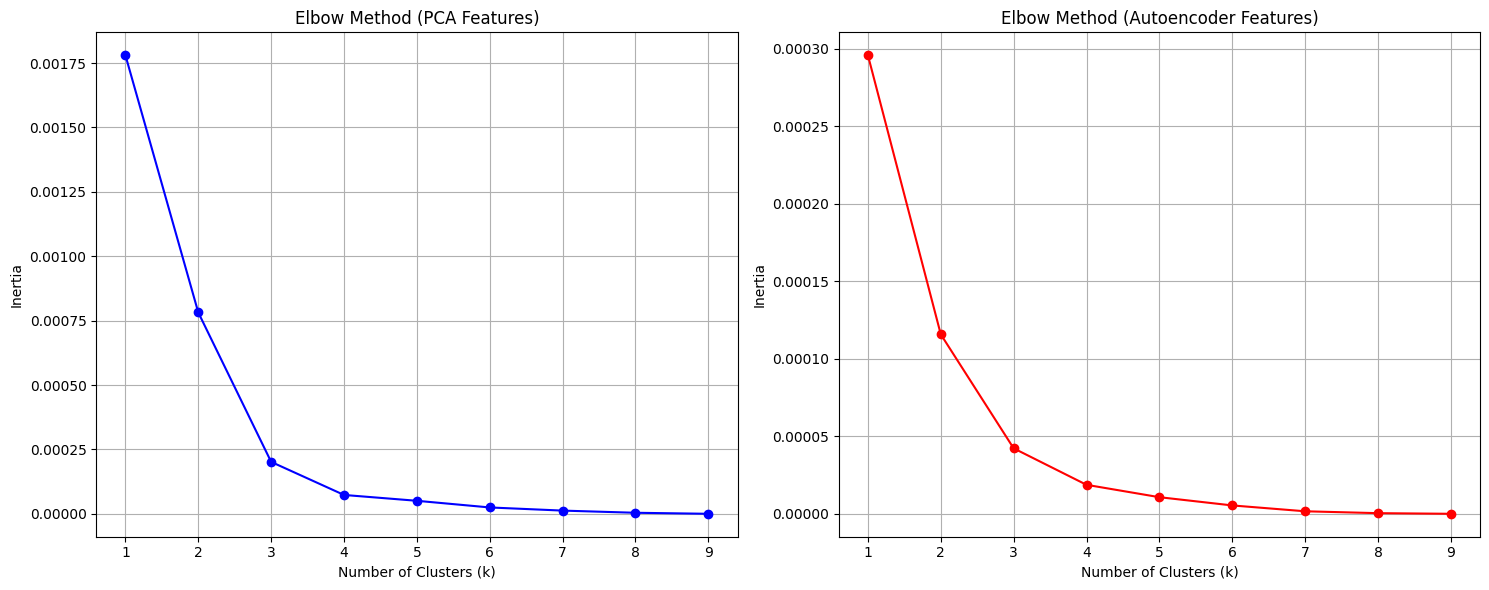

In [44]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Setup
k_range = range(1, 10)
pca_inertia = []
ae_inertia = []

# Calculate inertia for both methods
for k in k_range:
    # PCA clustering
    kmeans_pca = KMeans(n_clusters=k, random_state=42)
    kmeans_pca.fit(pca_exposures_df)
    pca_inertia.append(kmeans_pca.inertia_)
    
    # Autoencoder clustering
    kmeans_ae = KMeans(n_clusters=k, random_state=42)
    kmeans_ae.fit(factor_exposures_df)
    ae_inertia.append(kmeans_ae.inertia_)

# Create side-by-side plots
plt.figure(figsize=(15, 6))

# PCA plot
plt.subplot(1, 2, 1)
plt.plot(k_range, pca_inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method (PCA Features)')
plt.grid(True)

# Autoencoder plot
plt.subplot(1, 2, 2)
plt.plot(k_range, ae_inertia, 'ro-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method (Autoencoder Features)')
plt.grid(True)

plt.tight_layout()
plt.show()

- The plots suggest that 3 clusters is the optimal choice for both your PCA-based and autoencoder-based analyses. This is interesting because it means that both our linear (PCA) and nonlinear (autoencoder) dimensionality reduction techniques are identifying a similar underlying structure in your stock market data.

In [ ]:
from sklearn.cluster import KMeans

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


PCA-based clusters:
   Stock  Cluster
0   AAPL        0
1   AMZN        0
2   GOOG        0
3   META        0
4   MSFT        0
6   NVDA        0
8  ^GSPC        0
7   TSLA        1
5   NFLX        2

Autoencoder-based clusters:
   Stock  Cluster
3   META        0
6   NVDA        0
0   AAPL        1
1   AMZN        1
2   GOOG        1
4   MSFT        1
8  ^GSPC        1
5   NFLX        2
7   TSLA        2


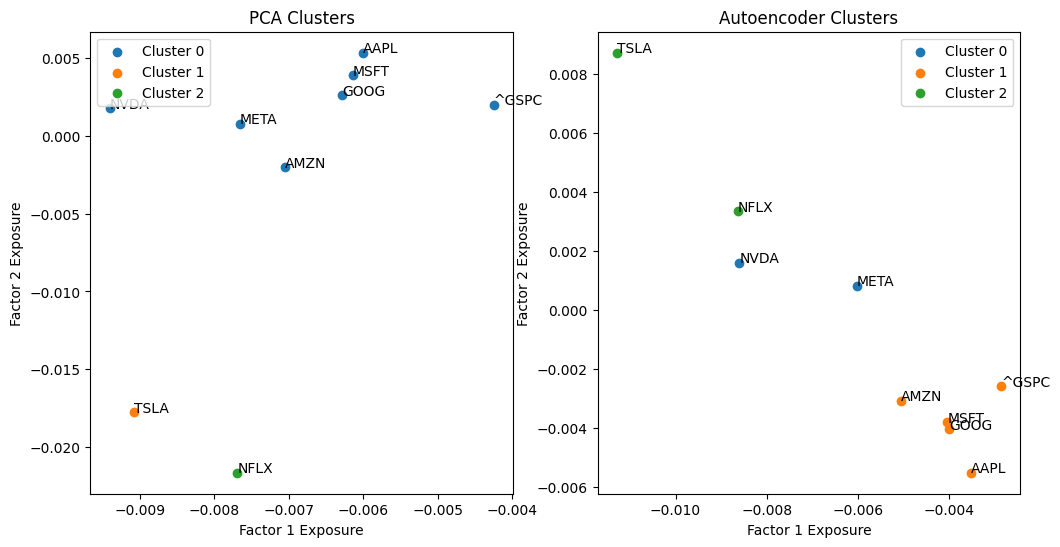

In [46]:

# Use PCA factor exposures as features for clustering
# This is simply the relationship between each stock and the 3 latent factors
n_clusters = 3  #same for both 
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
pca_clusters = kmeans.fit_predict(pca_exposures_df)
pca_cluster_results = pd.DataFrame({
    'Stock': yfinance_returns.columns,
    'Cluster': pca_clusters
})

print("PCA-based clusters:")
print(pca_cluster_results.sort_values('Cluster'))

# Similarly for autoencoder latent features
kmeans_ae = KMeans(n_clusters=n_clusters, random_state=42)
ae_clusters = kmeans_ae.fit_predict(factor_exposures_df)

# Create results dataframe
ae_cluster_results = pd.DataFrame({
    'Stock': yfinance_returns.columns,
    'Cluster': ae_clusters
})

print("\nAutoencoder-based clusters:")
print(ae_cluster_results.sort_values('Cluster'))

# Basic visualization
plt.figure(figsize=(12, 6))

# PCA clusters visualization - first 2 factors only for simplicity
plt.subplot(1, 2, 1)
for cluster in range(n_clusters):
    # Get stocks in this cluster
    cluster_stocks = pca_cluster_results[pca_cluster_results['Cluster'] == cluster]['Stock']
    # Plot their factor exposures
    plt.scatter(
        pca_exposures_df.loc[cluster_stocks, 'f1'],
        pca_exposures_df.loc[cluster_stocks, 'f2'],
        label=f'Cluster {cluster}'
    )
    # Label points with stock symbols
    for stock in cluster_stocks:
        plt.annotate(stock, (pca_exposures_df.loc[stock, 'f1'], pca_exposures_df.loc[stock, 'f2']))

plt.title('PCA Clusters')
plt.xlabel('Factor 1 Exposure')
plt.ylabel('Factor 2 Exposure')
plt.legend()

# Autoencoder clusters visualization
plt.subplot(1, 2, 2)
for cluster in range(n_clusters):
    # Get stocks in this cluster
    cluster_stocks = ae_cluster_results[ae_cluster_results['Cluster'] == cluster]['Stock']
    # Plot their factor exposures
    plt.scatter(
        factor_exposures_df.loc[cluster_stocks, 'f1'],
        factor_exposures_df.loc[cluster_stocks, 'f2'],
        label=f'Cluster {cluster}'
    )
    # Label points with stock symbols
    for stock in cluster_stocks:
        plt.annotate(stock, (factor_exposures_df.loc[stock, 'f1'], factor_exposures_df.loc[stock, 'f2']))

plt.title('Autoencoder Clusters')
plt.xlabel('Factor 1 Exposure')
plt.ylabel('Factor 2 Exposure')
plt.legend()

plt.show()

- TLDR: applies K-means clustering to stock exposure data from PCA (linear method), organizing stocks into three clusters based on their relationships to underlying market factors. 
- ANALYSIS 

- In PCA, most tech stocks are grouped together in Cluster 0 (AAPL, AMZN, GOOG, META, MSFT, NVDA, ^GSPC), while the autoencoder separates them differently.
- The autoencoder seems to have captured different relationships: NVDA and META form their own group (Cluster 0), most large cap tech (AAPL, AMZN, GOOG, MSFT) plus the S&P 500 index form Cluster 1 and NFLX and TSLA are grouped together in Cluster 2
- In both methods, TSLA and NFLX show distinctive behavior. In PCA, TSLA forms its own cluster (Cluster 1) and NFLX also forms its own cluster (Cluster 2). Interestingly, the autoencoder groups TSLA and NFLX together, suggesting it's detecting similarities not captured by linear PCA
- this supports our project hypothesis that nonlinear methods (autoencoder) can capture different relationships than linear methods (PCA). 

# claude code placeholder for anomalies

Implementing Z-score based anomaly detection...
Found 272 anomalous days using z-score method

Implementing Isolation Forest anomaly detection...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Found 33 anomalous days using Isolation Forest on raw returns

Implementing Isolation Forest on PCA factors...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Found 33 anomalous days using Isolation Forest on PCA factors

Implementing Isolation Forest on autoencoder factors...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Found 33 anomalous days using Isolation Forest on autoencoder factors

Implementing One-Class SVM anomaly detection...
Found 87 anomalous days using One-Class SVM on raw returns

Top anomalies detected by multiple methods:
          Date  Z-score  IF-Raw  IF-PCA  IF-AE  OCSVM  Detection_Count
264 2020-03-16     True    True    True   True   True                5
193 2020-02-27     True    True    True  False   True                4
225 2022-10-27     True   False    True   True   True                4
252 2020-04-06     True    True    True   True  False                4
181 2020-09-08     True    True    True  False   True                4
21  2022-02-03     True   False    True   True   True                4
245 2020-03-13     True    True    True  False   True                4
112 2020-03-12     True    True   False   True   True                4
273 2020-03-24     True    True    True   True  False                4
209 2020-03-02     True    True   False   True   True              

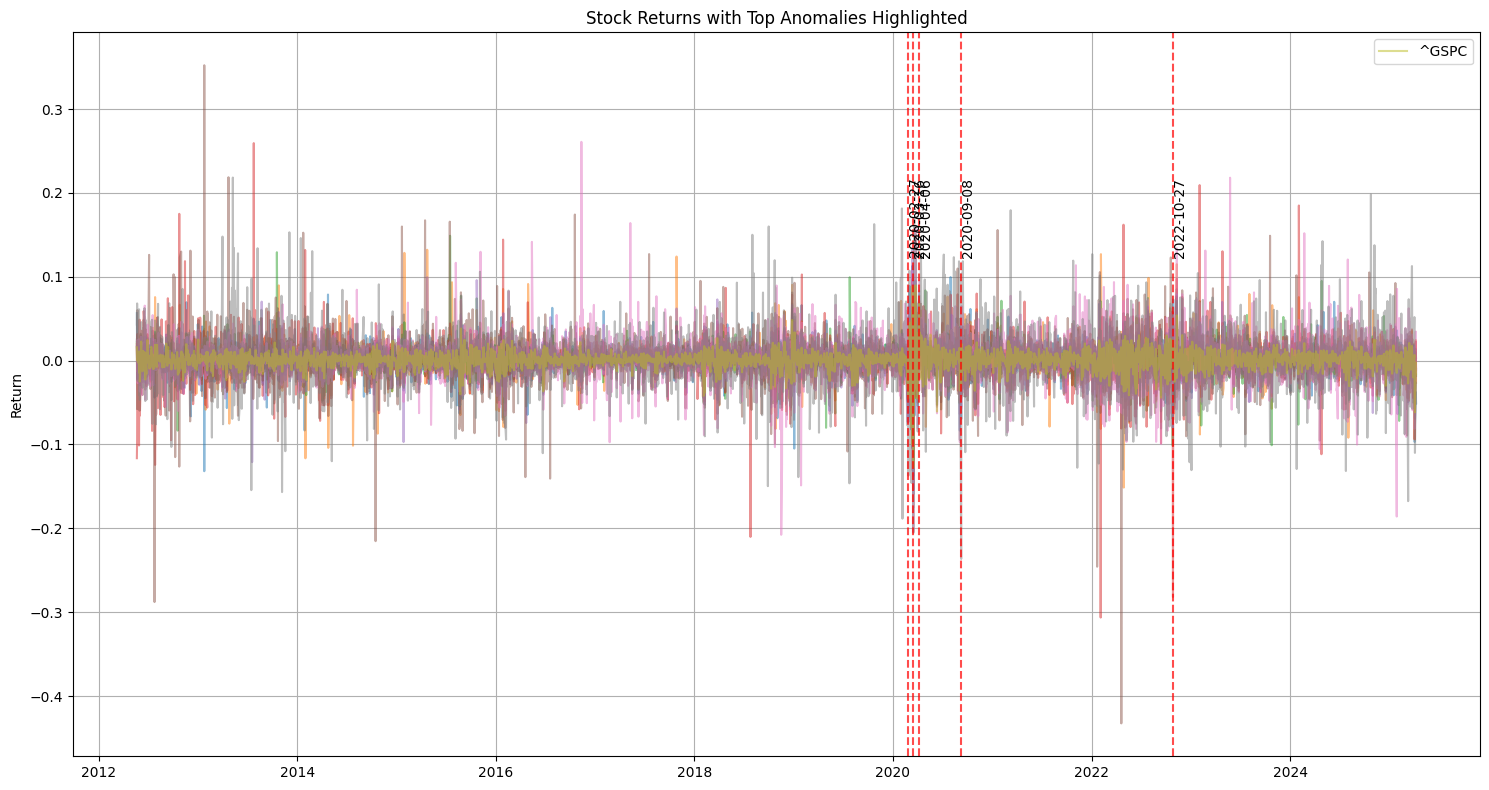


Investigate these dates to see if they correspond to major market events
such as the COVID crash, Fed announcements, or geopolitical events.


In [63]:
# Anomaly Detection Implementation
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Simple univariate approach (z-score method)
print("Implementing Z-score based anomaly detection...")
z_scores = (yfinance_returns - yfinance_returns.mean()) / yfinance_returns.std()

# Find max absolute z-score for each day (across all stocks)
max_z_by_day = abs(z_scores).max(axis=1)

# Identify anomalies (days with any z-score > 3)
z_anomalies = max_z_by_day[max_z_by_day > 3]
print(f"Found {len(z_anomalies)} anomalous days using z-score method")

# 2. Isolation Forest on raw returns
print("\nImplementing Isolation Forest anomaly detection...")
iso_forest = IsolationForest(
    n_estimators=100,
    contamination=0.01,  # Expect about 1% anomalies
    random_state=42
)
# Fit on raw returns
if_anomaly_scores_raw = iso_forest.fit_predict(yfinance_returns)
if_anomalies_raw = yfinance_returns.index[if_anomaly_scores_raw == -1]
print(f"Found {len(if_anomalies_raw)} anomalous days using Isolation Forest on raw returns")

# 3. Isolation Forest on PCA factors
print("\nImplementing Isolation Forest on PCA factors...")
iso_forest_pca = IsolationForest(
    n_estimators=100,
    contamination=0.01,
    random_state=42
)
# Fit on PCA factors
if_anomaly_scores_pca = iso_forest_pca.fit_predict(pca_returns_df)
if_anomalies_pca = pca_returns_df.index[if_anomaly_scores_pca == -1]
print(f"Found {len(if_anomalies_pca)} anomalous days using Isolation Forest on PCA factors")

# 4. Isolation Forest on autoencoder latent features
print("\nImplementing Isolation Forest on autoencoder factors...")
iso_forest_ae = IsolationForest(
    n_estimators=100,
    contamination=0.01,
    random_state=42
)
# Fit on autoencoder factors
if_anomaly_scores_ae = iso_forest_ae.fit_predict(factor_returns_df)
if_anomalies_ae = factor_returns_df.index[if_anomaly_scores_ae == -1]
print(f"Found {len(if_anomalies_ae)} anomalous days using Isolation Forest on autoencoder factors")

# 5. One-Class SVM on raw returns
print("\nImplementing One-Class SVM anomaly detection...")
ocsvm = OneClassSVM(
    kernel='rbf',
    gamma='scale',
    nu=0.01  # Similar to contamination
)
# Fit on raw returns
ocsvm_scores_raw = ocsvm.fit_predict(yfinance_returns)
ocsvm_anomalies_raw = yfinance_returns.index[ocsvm_scores_raw == -1]
print(f"Found {len(ocsvm_anomalies_raw)} anomalous days using One-Class SVM on raw returns")

# Compare results
all_anomalies = pd.DataFrame({
    'Date': pd.Series(list(set(
        z_anomalies.index.tolist() + 
        if_anomalies_raw.tolist() + 
        if_anomalies_pca.tolist() + 
        if_anomalies_ae.tolist() + 
        ocsvm_anomalies_raw.tolist()
    ))).sort_values(),
})

# Mark which methods detected each anomaly
all_anomalies['Z-score'] = all_anomalies['Date'].isin(z_anomalies.index)
all_anomalies['IF-Raw'] = all_anomalies['Date'].isin(if_anomalies_raw)
all_anomalies['IF-PCA'] = all_anomalies['Date'].isin(if_anomalies_pca)
all_anomalies['IF-AE'] = all_anomalies['Date'].isin(if_anomalies_ae)
all_anomalies['OCSVM'] = all_anomalies['Date'].isin(ocsvm_anomalies_raw)

# Count how many methods detected each anomaly
all_anomalies['Detection_Count'] = all_anomalies.iloc[:, 1:].sum(axis=1)

# Sort by number of methods that detected each anomaly
all_anomalies = all_anomalies.sort_values('Detection_Count', ascending=False)

print("\nTop anomalies detected by multiple methods:")
print(all_anomalies.head(10))

# Visualize some top anomalies on the return series
plt.figure(figsize=(15, 8))
for stock in yfinance_returns.columns:
    plt.plot(yfinance_returns.index, yfinance_returns[stock], alpha=0.5, label=stock if stock == '^GSPC' else '')

# Highlight top anomalies
for date in all_anomalies.head(5)['Date']:
    plt.axvline(x=date, color='r', linestyle='--', alpha=0.7)
    plt.text(date, yfinance_returns.loc[date:].max().max(), date.strftime('%Y-%m-%d'), 
             rotation=90, verticalalignment='top')

plt.title('Stock Returns with Top Anomalies Highlighted')
plt.ylabel('Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Check if anomalies correspond to known market events
print("\nInvestigate these dates to see if they correspond to major market events")
print("such as the COVID crash, Fed announcements, or geopolitical events.")

In [64]:
# For a specific anomaly date
anomaly_date = '2022-10-27'
print(f"Returns on {anomaly_date}:")
print(yfinance_returns.loc[anomaly_date])

# Compare to average returns
print("\nAverage daily returns:")
print(yfinance_returns.mean())

# Look at market conditions around the anomaly
window_days = 5  # 5 days before and after
start_date = pd.to_datetime(anomaly_date) - pd.Timedelta(days=window_days)
end_date = pd.to_datetime(anomaly_date) + pd.Timedelta(days=window_days)
print(f"\nMarket context ({window_days} days before and after):")
print(yfinance_returns.loc[start_date:end_date])

Returns on 2022-10-27:
Ticker
AAPL    -0.030939
AMZN    -0.041485
GOOG    -0.023691
META    -0.281794
MSFT    -0.019954
NFLX    -0.005642
NVDA     0.021480
TSLA     0.002001
^GSPC   -0.006101
Name: 2022-10-27 00:00:00, dtype: float64

Average daily returns:
Ticker
AAPL     0.000735
AMZN     0.000855
GOOG     0.000706
META     0.000801
MSFT     0.000840
NFLX     0.001379
NVDA     0.001806
TSLA     0.001480
^GSPC    0.000416
dtype: float64

Market context (5 days before and after):
Ticker          AAPL      AMZN      GOOG      META      MSFT      NFLX  \
Date                                                                     
2022-10-24  0.014694  0.004182  0.014576 -0.002233  0.020967 -0.024896   
2022-10-25  0.019153  0.006489  0.018856  0.058318  0.013697  0.029890   
2022-10-26 -0.019822 -0.041824 -0.101313 -0.057548 -0.080295  0.025780   
2022-10-27 -0.030939 -0.041485 -0.023691 -0.281794 -0.019954 -0.005642   
2022-10-28  0.072834 -0.070468  0.042083  0.012783  0.039433 -0.004117 